# # Predict the close price of S&P500 index using LSTM-RNN

# Import module

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import CuDNNLSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import tensorflow as tf
from keras.callbacks import *

Using TensorFlow backend.


## Check the device and python version

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print (sys.version)
print(sys.executable)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 141678688724173381
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7634098586
locality {
  bus_id: 1
}
incarnation: 440643577409222877
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
3.4.3 (default, Nov 17 2016, 01:08:31) 
[GCC 4.8.4]
/home/tonyzhang1231/.virtualenvs/nyse/bin/python


# Input parameters 

In [3]:
stock_name = '^GSPC' # S&P 500 (^GSPC)  index
start = datetime.date(1950, 1, 1)
end = datetime.date.today()

In [4]:
print('startDate: {}, endDate: {}'.format(start, end))

startDate: 1950-01-01, endDate: 2017-11-24


# Part 0. Download data and normalize it
Data since 1950 to today

In [5]:
# 1. use today's data and tomorrow open price to predict tomorrow's close price

def get_stock_data(stock_name, start, end, normalize=True):
    df = web.DataReader(stock_name, "yahoo", start, end)
    print ("origina data\n")
    print (df.head(10))
    
    df.drop(['Close'], 1, inplace=True)
    df['Volume'] = df['Volume'].astype(float)
    df = df[['Open','Volume','High','Low','Adj Close']]

    if normalize:        
        price_scaler = preprocessing.MinMaxScaler()
        price_scaler.fit(df['Open'].values.reshape(-1,1))
        volume_scaler = preprocessing.MinMaxScaler()
        volume_scaler.fit(df['Volume'].values.reshape(-1,1))
        df['Open'] = price_scaler.transform(df.Open.values.reshape(-1,1))
        df['High'] = price_scaler.transform(df.High.values.reshape(-1,1))
        df['Low'] = price_scaler.transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = price_scaler.transform(df['Adj Close'].values.reshape(-1,1))
        df['Volume'] = volume_scaler.transform(df['Volume'].values.reshape(-1,1))
    return df, price_scaler, volume_scaler


def load_data(df, seq_len):
    amount_of_features = len(df.columns)
    data = df.as_matrix()  # convert dataframe to np array
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = int(round(0.9 * result.shape[0])) # 90% split
    
    # train
    train = result[:row, :] # first 90% date
    X_train = train[:, :-1] # all data until day m

    y_train = train[:, -1][:,-1] # day m + 1 
    
    # test
    test = result[row:, :]
    X_test = test[:, :-1]

    y_test = test[:, -1][:,-1]  # day m + 1 
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [7]:
df, price_scaler, volume_scaler = get_stock_data(stock_name, start, end)

origina data

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
1950-01-03  16.660000  16.660000  16.660000  16.660000  16.660000  1260000
1950-01-04  16.850000  16.850000  16.850000  16.850000  16.850000  1890000
1950-01-05  16.930000  16.930000  16.930000  16.930000  16.930000  2550000
1950-01-06  16.980000  16.980000  16.980000  16.980000  16.980000  2010000
1950-01-09  17.090000  17.090000  17.080000  17.080000  17.080000  3850000
1950-01-10  17.030001  17.030001  17.030001  17.030001  17.030001  2160000
1950-01-11  17.090000  17.090000  17.090000  17.090000  17.090000  2630000
1950-01-12  16.760000  16.760000  16.760000  16.760000  16.760000  2970000
1950-01-13  16.670000  16.670000  16.670000  16.670000  16.670000  3330000
1950-01-16  16.650000  16.719999  16.650000  16.719999  16.719999  2640000


In [8]:
df.tail(10)

Open    Volume      High       Low  Adj Close
Date                                                         
2017-11-10  0.992166  0.304323  0.993571  0.990382   0.992987
2017-11-13  0.990754  0.296992  0.995061  0.989960   0.993970
2017-11-14  0.991226  0.317841  0.991965  0.986895   0.991660
2017-11-15  0.988014  0.310607  0.989326  0.983369   0.986144
2017-11-16  0.989368  0.289116  0.996002  0.989368   0.994280
2017-11-17  0.993235  0.288021  0.993629  0.991176   0.991652
2017-11-20  0.991899  0.262128  0.993893  0.991416   0.992925
2017-11-21  0.995646  0.290863  1.000298  0.995646   0.999462
2017-11-22  0.999957  0.241125  1.000201  0.997991   0.998707
2017-11-24  1.000000  0.063510  1.001467  1.000000   1.000774

In [9]:
seq_len = 22

X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [10]:
print (X_train.shape)
print (X_test.shape)

(15357, 22, 5)
(1706, 22, 5)


In [11]:
print (y_train.shape)
print (y_test.shape)

(15357,)
(1706,)


### TODO: add More Features here


In [12]:
print (df.count())

Open         17086
Volume       17086
High         17086
Low          17086
Adj Close    17086
dtype: int64


In [13]:
df.tail()

Open    Volume      High       Low  Adj Close
Date                                                         
2017-11-17  0.993235  0.288021  0.993629  0.991176   0.991652
2017-11-20  0.991899  0.262128  0.993893  0.991416   0.992925
2017-11-21  0.995646  0.290863  1.000298  0.995646   0.999462
2017-11-22  0.999957  0.241125  1.000201  0.997991   0.998707
2017-11-24  1.000000  0.063510  1.001467  1.000000   1.000774

### Plot out the Normalized Adjusted close price and Return

In [14]:
def plot_close_price(df):
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()
    
# def plot_return(df):
#     plt.plot(df['DailyReturn'], color='green', label='Daily_Return')
#     plt.legend(loc='best')
#     plt.show()

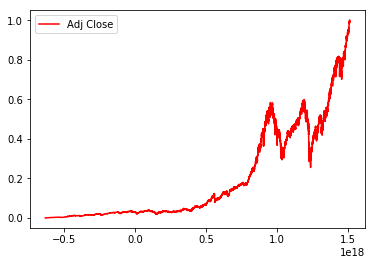

In [15]:
try:
    plot_close_price(df)
except:
    pass

# Part 1. Building LSTM RNN (Base)

In [16]:
def build_model_base(input_shape, neurons, dropout, lr_decay = 0.9, loadmodelFilepath= None):
    model = Sequential()
    
    model.add(CuDNNLSTM(neurons[0], input_shape=(input_shape[0], input_shape[1]), return_sequences=True))
    model.add(Dropout(dropout))
        
    model.add(CuDNNLSTM(neurons[1], input_shape=(input_shape[0], input_shape[1]), return_sequences=False))
    model.add(Dropout(dropout))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    if loadmodelFilepath:
        try:
            model = load_model(loadmodelFilepath)
        except:
            pass
    
    adam = keras.optimizers.Adam(lr= 0.01, decay=lr_decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

###  Model Execution

In [17]:
# callbacks = []
callbacks = [
    ModelCheckpoint(filepath='../model/baseModel.hdf5', \
                    monitor='val_loss', save_best_only=True, verbose=0, mode= 'auto', period=5),

]

### Parameters

In [18]:
# Parameters : dropout, neurons, epochs, learning rate decay, epochs, seq_len

dropout = 0.1
neurons = [128, 128, 32, 1]
epochs = 300

shape = [X_train.shape[1], X_train.shape[2]] 
model = build_model_base(shape, neurons, dropout, lr_decay=0.7)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 22, 128)           69120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable params: 0
_________________________________________________________________


### Training

In [19]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    callbacks = callbacks,
    validation_split=0.1,
    verbose=1)

### Training loss and val loss along with epochs

In [20]:
def plotTrainTestLoss(history):
    assert isinstance(history, keras.callbacks.History), "input must be a keras.callbacks.History instance"
    train_metrics = history.history
    plt.close('all')
    f, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.plot(train_metrics['loss'], color='blue', label='train_loss')
    ax1.legend(loc='best')
    
    ax2.plot(train_metrics['val_loss'], color='red', label='val_loss')
    ax2.legend(loc='best')
    f.subplots_adjust(hspace=0.1)
    plt.xlabel("Epochs")
    plt.show()

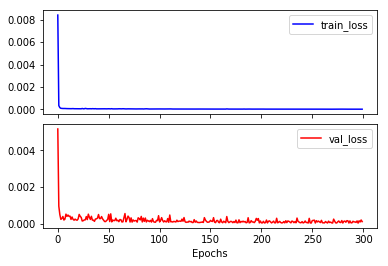

In [21]:
plotTrainTestLoss(history)

### Result on training set and testing set

In [22]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [23]:
thisBestModel = load_model('../model/baseModel.hdf5')
model_score(thisBestModel, X_train, y_train, X_test, y_test)
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00001 MSE (0.00359 RMSE)
Test Score: 0.00005 MSE (0.00727 RMSE)
Train Score: 0.00002 MSE (0.00445 RMSE)
Test Score: 0.00022 MSE (0.01491 RMSE)


(1.9803771081016217e-05, 0.0002223021329101066)

### Prediction vs Real results

In [24]:
def getPrediction(model, X_test, y_test, price_scaler=None, denormalize=False):
    p = model.predict(X_test)
    price = None
    if denormalize and price_scaler:
        price = price_scaler.inverse_transform(p)
    
    return p, price

def plot_result(stock_name, normalized_p, normalized_value_y_test):
    plt.plot(normalized_p, color='red', label='Prediction')
    plt.plot(normalized_value_y_test,color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('The test result for {}'.format(stock_name))
    plt.xlabel('Days')
    plt.ylabel('Adjusted Close')
    plt.show()
    
def plotTrainFitAndTestPrediction(model, X_train, y_train, X_test, y_test):
    p, _ = getPrediction(model, X_test, y_test)
    plot_result(stock_name, p, y_test)
    train_p, _ = getPrediction(model, X_train, y_train)
    plot_result(stock_name, train_p, y_train)

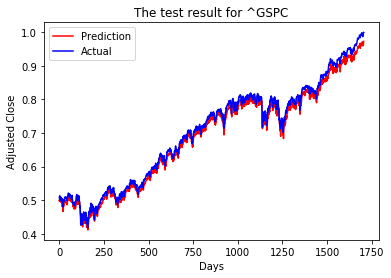

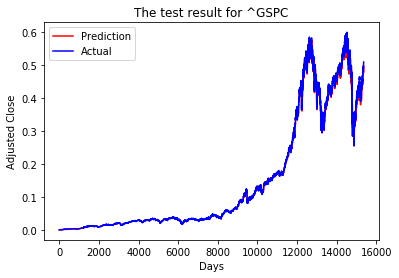

In [25]:
plotTrainFitAndTestPrediction(model, X_train, y_train, X_test, y_test)

### Save model at last epoch

In [31]:
model.save('../model/baseModel-epoch:{:02d}.hdf5'.format(epochs))

# Part 2. Fine tune model (Optimization)


In [32]:
# remember we have Parameters : 
# dropout, lr_decay, 
# epochs, seq_len, neurons, 

In [33]:
stock_name = '^GSPC'

# Currently we fix following params, tune dropout, decay, 
seq_len = 22
epochs = 300
neurons = [128, 128, 32, 1]
shape = [X_train.shape[1], X_train.shape[2]]
lr_decay = 0.5

In [35]:
def tuning_model(stock_name, seq_len, dropout, lr_decay, shape, neurons, epochs, X_train, y_train, X_test, y_test):
    model = build_model_base(shape, neurons, dropout, lr_decay, loadmodelFilepath=None)
    
    
    callbacks = [
    ModelCheckpoint(filepath='../model/optModel-dropout: {:02f}-lr_decay: {:02f}.hdf5'.format(dropout, lr_decay) , \
                    monitor='val_loss', save_best_only=True, verbose=0, mode= 'auto', period=1),

    ]
    
    
    history = model.fit(X_train, y_train,batch_size=512,epochs=epochs,callbacks = callbacks, \
                        validation_split=0.1,verbose=1)
    
    # do some plots
    plotTrainTestLoss(history)
    plotTrainFitAndTestPrediction(model, X_train, y_train, X_test, y_test)
    
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

### Optimial Dropout value

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 22, 128)           69120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable params: 0
_________________________________________________________________
Trai

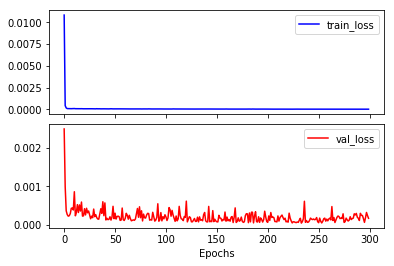

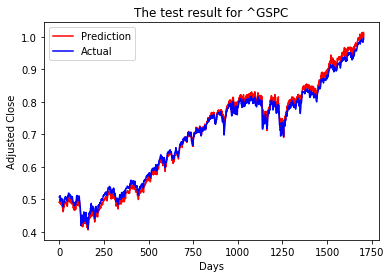

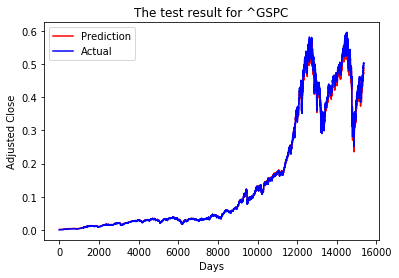

Train Score: 0.00003 MSE (0.00546 RMSE)
Test Score: 0.00017 MSE (0.01292 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 22, 128)           69120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

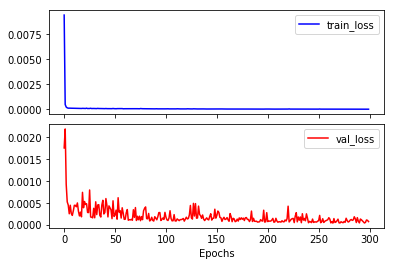

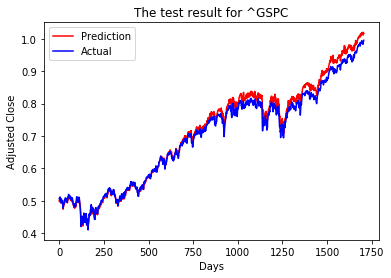

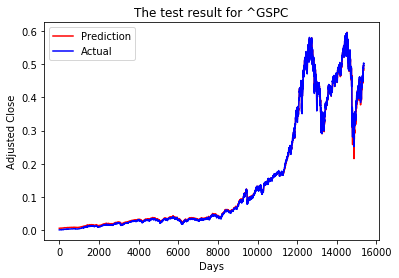

Train Score: 0.00002 MSE (0.00436 RMSE)
Test Score: 0.00031 MSE (0.01764 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 22, 128)           69120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

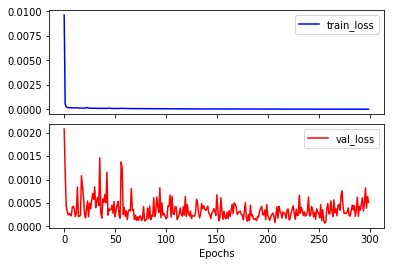

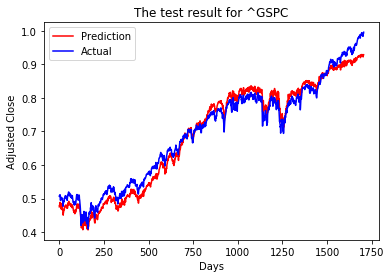

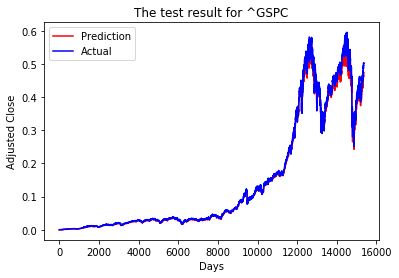

Train Score: 0.00008 MSE (0.00916 RMSE)
Test Score: 0.00066 MSE (0.02562 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, 22, 128)           69120     
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

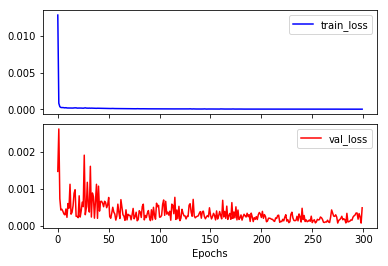

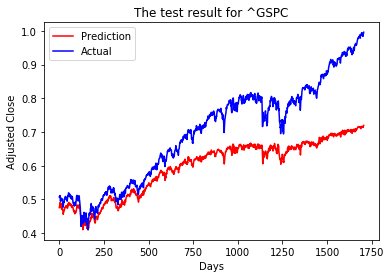

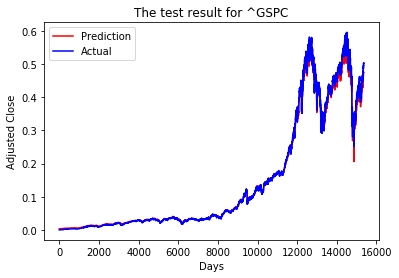

Train Score: 0.00008 MSE (0.00871 RMSE)
Test Score: 0.01529 MSE (0.12366 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_11 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_11 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

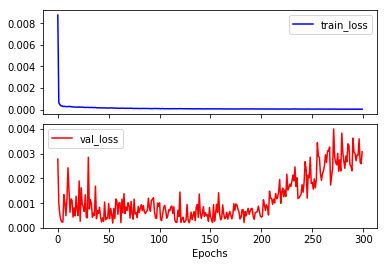

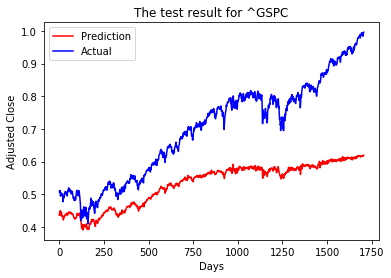

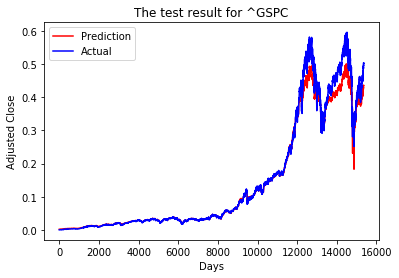

Train Score: 0.00052 MSE (0.02281 RMSE)
Test Score: 0.03538 MSE (0.18808 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_13 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

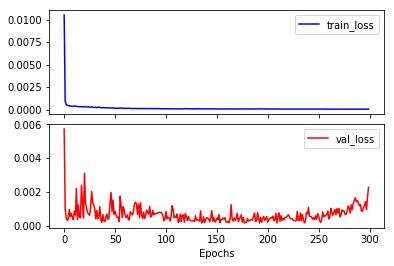

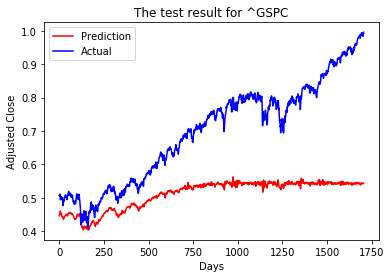

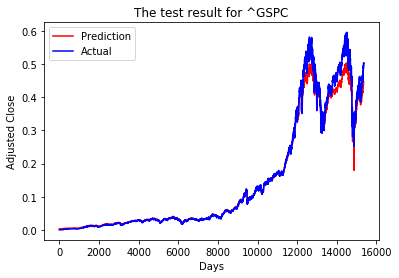

Train Score: 0.00038 MSE (0.01944 RMSE)
Test Score: 0.04743 MSE (0.21780 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_15 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_15 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

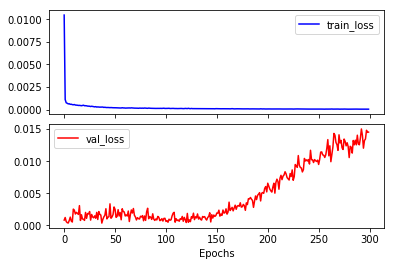

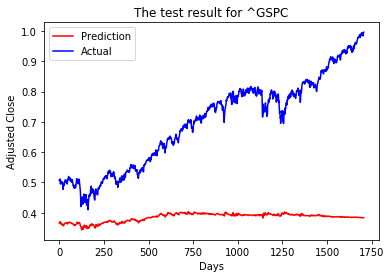

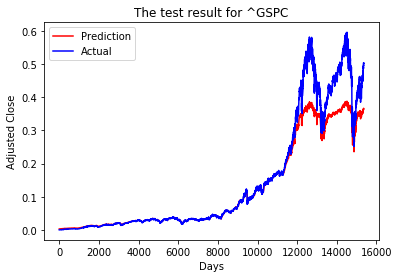

Train Score: 0.00275 MSE (0.05242 RMSE)
Test Score: 0.11795 MSE (0.34344 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_17 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

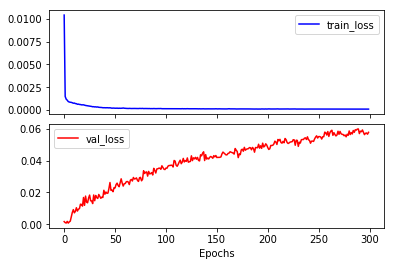

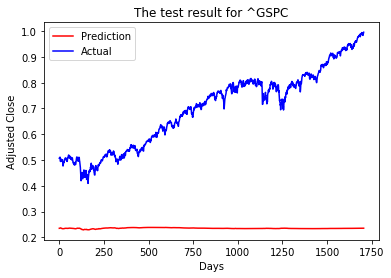

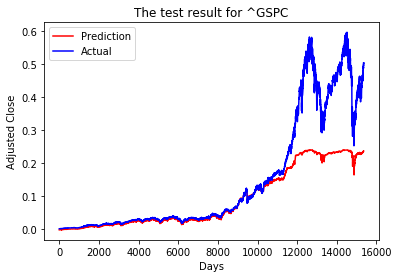

Train Score: 0.01159 MSE (0.10766 RMSE)
Test Score: 0.23632 MSE (0.48613 RMSE)


In [36]:
dropout_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
dropout_result = {}
lr_decay = 0.5

for dropout in dropout_list:    
    trainScore, testScore = tuning_model(stock_name, seq_len, dropout, lr_decay, shape, neurons, epochs,\
                                          X_train, y_train, X_test, y_test)
    dropout_result[dropout] = [trainScore, testScore]

In [42]:
print (dropout_result)
minv = dropout_result[0.1][1]
opt_dropout = 0.1
for k,v in dropout_result.items():
    if v[1] < minv:
        opt_dropout = k
        minv = v[1]
        
opt_dropout
        
    

# min_val = min(dropout_result.values())
# min_val_key = [k for k, v in dropout_result.items() if v == min_val]
# print (dropout_result)
# print (min_val_key)

# opt_dropout = min_val_key[0]

{0.1: [2.9816522392439596e-05, 0.0001668015980017879], 0.2: [1.9020301873139385e-05, 0.00031120927430086648], 0.3: [8.3814195244286498e-05, 0.00065627625672821422], 0.6: [0.00037781360985463696, 0.047434757783537312], 0.8: [0.011591471246362632, 0.23632457226969014], 0.5: [0.00052027876815807631, 0.035375031774726035], 0.7: [0.002747519944831048, 0.11794817370798216], 0.4: [7.587048497392692e-05, 0.015292113745674614]}


0.1

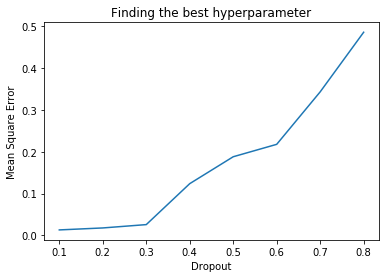

In [55]:
lists = sorted(dropout_result.items())
x,y = zip(*lists)
y = [math.sqrt(z[1]) for z in y]
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

### Optimal lr_decay

In [53]:
lr_decay_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lr_decay_result = {}
opt_dropout = 0.1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_19 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_19 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_20 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable params: 0
_________________________________________________________________
Trai

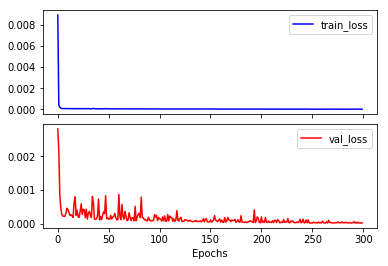

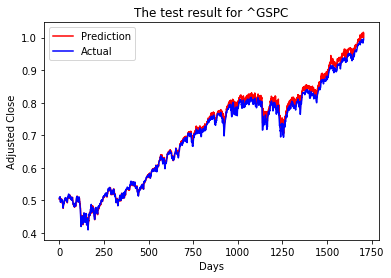

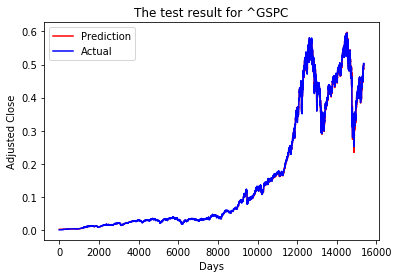

Train Score: 0.00001 MSE (0.00250 RMSE)
Test Score: 0.00014 MSE (0.01186 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_21 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_21 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

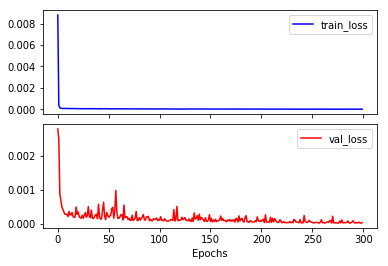

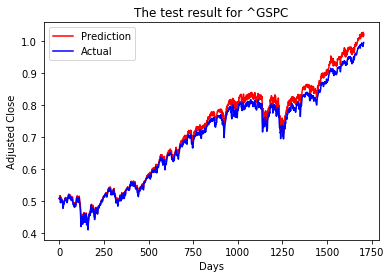

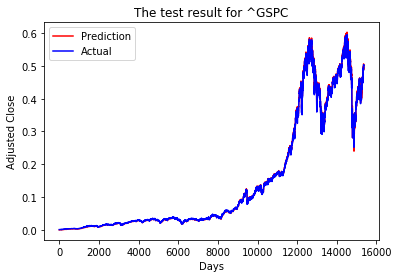

Train Score: 0.00001 MSE (0.00328 RMSE)
Test Score: 0.00038 MSE (0.01940 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_23 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_23 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_24 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

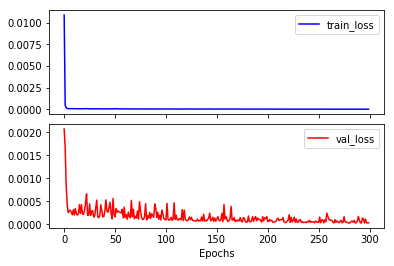

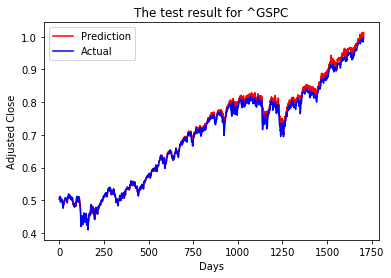

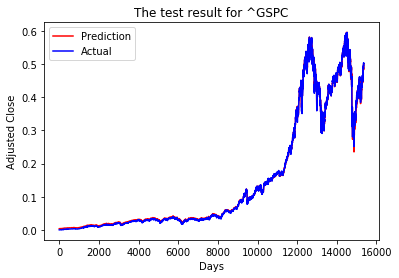

Train Score: 0.00001 MSE (0.00332 RMSE)
Test Score: 0.00011 MSE (0.01059 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_25 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_25 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_26 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

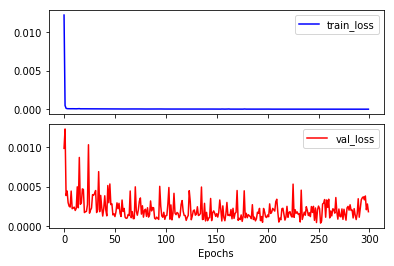

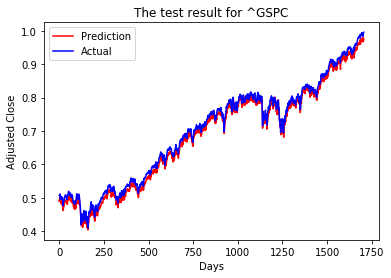

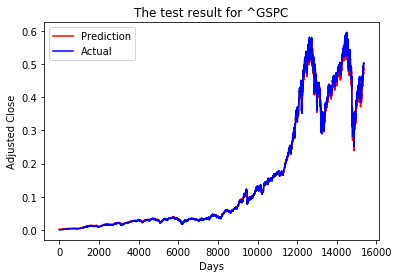

Train Score: 0.00003 MSE (0.00573 RMSE)
Test Score: 0.00016 MSE (0.01277 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_27 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_27 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_28 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

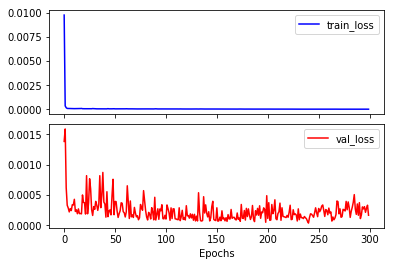

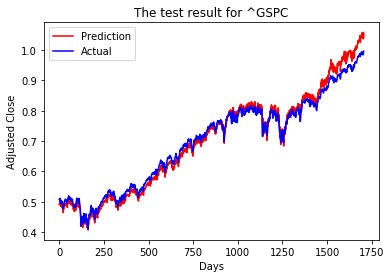

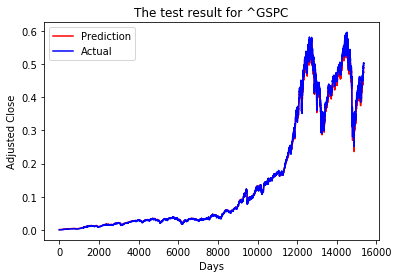

Train Score: 0.00003 MSE (0.00560 RMSE)
Test Score: 0.00039 MSE (0.01972 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_29 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_29 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_30 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

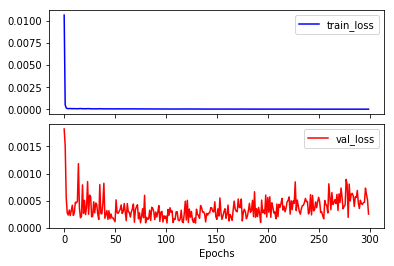

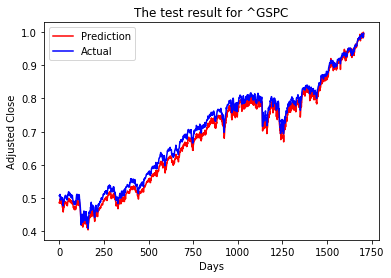

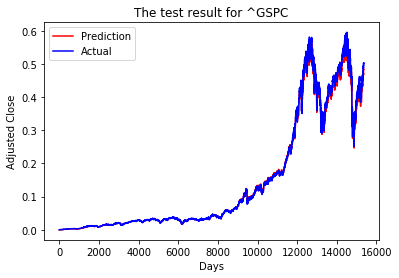

Train Score: 0.00004 MSE (0.00668 RMSE)
Test Score: 0.00034 MSE (0.01833 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_31 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_31 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_32 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

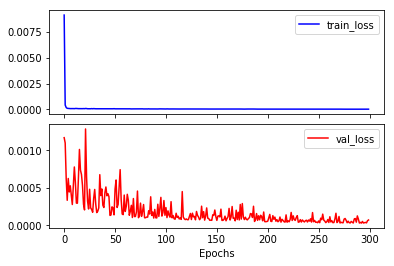

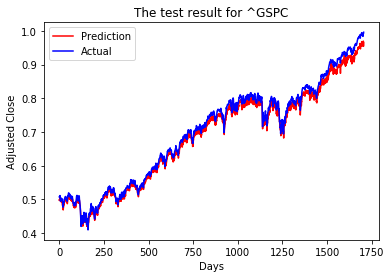

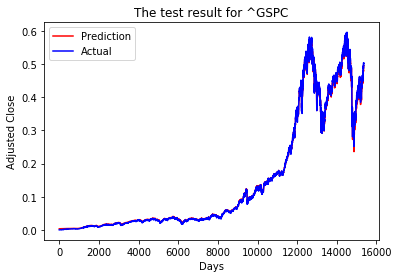

Train Score: 0.00001 MSE (0.00364 RMSE)
Test Score: 0.00020 MSE (0.01411 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_33 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_33 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_34 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

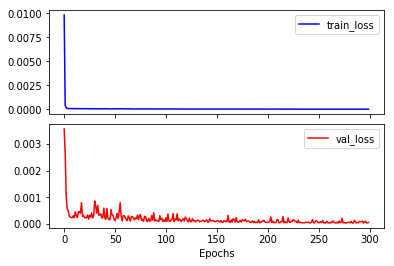

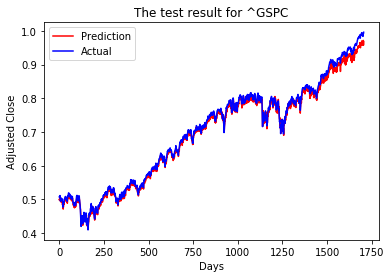

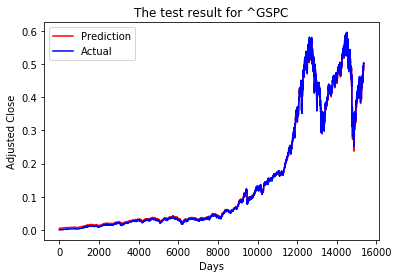

Train Score: 0.00002 MSE (0.00415 RMSE)
Test Score: 0.00010 MSE (0.01000 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_35 (CuDNNLSTM)    (None, 22, 128)           69120     
_________________________________________________________________
dropout_35 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
cu_dnnlstm_36 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable p

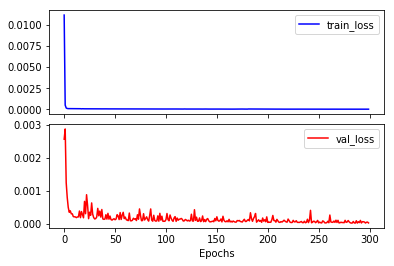

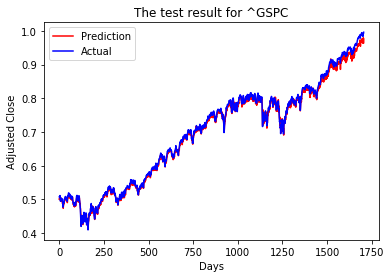

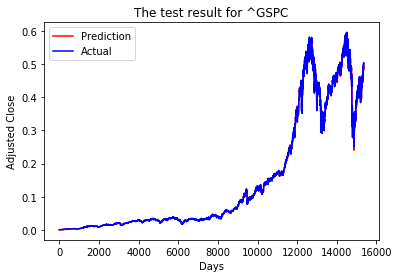

Train Score: 0.00001 MSE (0.00239 RMSE)
Test Score: 0.00006 MSE (0.00779 RMSE)


In [54]:
for lr_decay in lr_decay_list:    
    trainScore, testScore = tuning_model(stock_name, seq_len, opt_dropout, lr_decay, shape, neurons, epochs,\
                                          X_train, y_train, X_test, y_test)
    lr_decay_result[lr_decay] = [trainScore, testScore]

In [57]:
print (lr_decay_result)
minv = lr_decay_result[0.1][1]
opt_lr_decay = 0.1
for k,v in lr_decay_result.items():
    if v[1] < minv:
        opt_lr_decay = k
        minv = v[1]
        
opt_lr_decay

{0.1: [6.240906852136721e-06, 0.00014056515186486803], 0.2: [1.0736063153166111e-05, 0.00037621578268116126], 0.3: [1.1031195447802401e-05, 0.00011219054077433123], 0.6: [4.4621909321772873e-05, 0.00033615876860326147], 0.8: [1.724865405200965e-05, 0.00010001026758605315], 0.5: [3.1317257354794646e-05, 0.00038902075607891894], 0.7: [1.3255174821661963e-05, 0.00019916826440130578], 0.9: [5.7326554467258883e-06, 6.0741308214555623e-05], 0.4: [3.2792962120776773e-05, 0.00016308642520813832]}


0.9

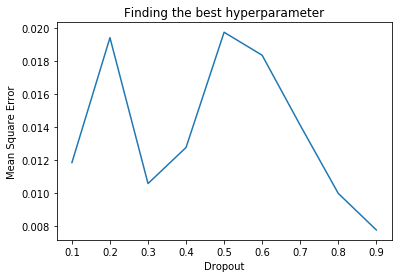

In [58]:
lists = sorted(lr_decay_result.items())
x,y = zip(*lists)
y = [math.sqrt(z[1]) for z in y]
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

# Show the best result

In [137]:
print (opt_dropout)
print (opt_lr_decay)

NameError: name 'opt_dropout' is not defined

In [34]:
best_model = load_model('../model/optModel-dropout: 0.100000-lr_decay: 0.900000.hdf5')
model_score(best_model, X_train, y_train, X_test, y_test)

Train Score: 0.00001 MSE (0.00325 RMSE)
Test Score: 0.00006 MSE (0.00765 RMSE)


(1.0546617660904404e-05, 5.8551531677829823e-05)

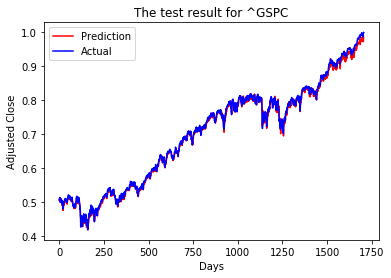

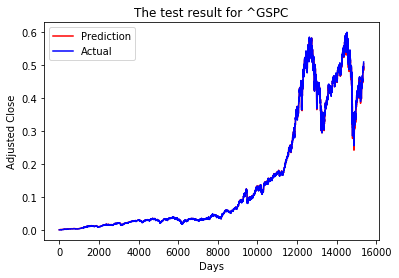

In [35]:
plotTrainFitAndTestPrediction(best_model, X_train, y_train, X_test, y_test)

### Compare with naive result (close price of last day)

In [36]:
def rmse(pred, truth, firstk = None):
    firstk = firstk or pred.shape[0]
    return np.sqrt(np.mean( (pred[:firstk+1]-truth[:firstk+1])**2))

In [37]:
pred = best_model.predict(X_test).flatten()

In [41]:
rmse(pred, y_test)

0.0076518966828298916

In [42]:
naive = X_test[:,-1,-1]

In [45]:
rmse(naive, y_test)

0.0057772929707193433

In [46]:
df = pd.DataFrame([y_test,naive,pred]).T
df.columns = ['y_test','naive','pred']

In [49]:
df

y_test     naive      pred
0     0.507537  0.509206  0.506244
1     0.510754  0.507537  0.503221
2     0.512344  0.510754  0.510522
3     0.513343  0.512344  0.509248
4     0.502672  0.513343  0.513306
5     0.499561  0.502672  0.502903
6     0.499058  0.499561  0.500523
7     0.504391  0.499058  0.499817
8     0.507232  0.504391  0.501375
9     0.499147  0.507232  0.510201
10    0.499963  0.499147  0.500536
11    0.508683  0.499963  0.500630
12    0.504882  0.508683  0.503282
13    0.500617  0.504882  0.501852
14    0.505142  0.500617  0.497924
15    0.504445  0.505142  0.499022
16    0.494804  0.504445  0.499745
17    0.498353  0.494804  0.488936
18    0.495300  0.498353  0.494018
19    0.489680  0.495300  0.488654
20    0.480008  0.489680  0.480602
21    0.486526  0.480008  0.475375
22    0.488650  0.486526  0.483331
23    0.496070  0.488650  0.483721
24    0.494286  0.496070  0.490481
25    0.495745  0.494286  0.491059
26    0.500435  0.495745  0.490001
27    0.502038  0.500435  0.495991
28    0.500641  0.502038  0.498308
29    0.504221  0.500641  0.498995
...        ...       ...       ...
1676  0.980846  0.982514  0.968497
1677  0.981713  0.980846  0.965634
1678  0.983443  0.981713  0.969712
1679  0.984109  0.983443  0.968981
1680  0.984844  0.984109  0.969289
1681  0.985169  0.984844  0.971316
1682  0.990243  0.985169  0.967280
1683  0.986284  0.990243  0.979493
1684  0.987890  0.986284  0.968324
1685  0.983253  0.987890  0.974923
1686  0.984511  0.983253  0.963553
1687  0.992511  0.984511  0.976667
1688  0.989322  0.992511  0.977312
1689  0.990262  0.989322  0.972321
1690  0.991849  0.990262  0.976896
1691  0.992039  0.991849  0.977756
1692  0.995131  0.992039  0.973291
1693  0.996404  0.995131  0.983777
1694  0.996215  0.996404  0.978535
1695  0.997662  0.996215  0.980849
1696  0.993885  0.997662  0.981723
1697  0.992987  0.993885  0.973420
1698  0.993970  0.992987  0.981804
1699  0.991660  0.993970  0.976942
1700  0.986144  0.991660  0.974764
1701  0.994280  0.986144  0.971621
1702  0.991652  0.994280  0.986068
1703  0.992925  0.991652  0.972245
1704  0.999462  0.992925  0.982112
1705  0.998707  0.999462  0.984747

[1706 rows x 3 columns]

# LSTM is better than NN , but still worse than naive result

# TODO: add more features to improve the result